# New script to create (transient) storm surge heights
(This needs to be combined with sea level rise scenario to obtain storm surge *levels*

In [1]:
import sys

sys.path.append("..") #import folder which is one level higher

from classes import *
import numpy as np
import pandas as pd

### Gumbel equation
# $ F(x,\mu,\beta) = exp(-e^{(\mu-x)/\beta}) $

### Generate new SurgeHeight series using the Gumbel distribution for Hoek van Holland

Sterl, A., van den Brink, H., de Vries, H., Haarsma, R., & van Meijgaard, E. (2009). An ensemble study of extreme storm surge related water levels in the North Sea in a changing climate. Ocean Science, 5(3), 369–378. https://doi.org/10.5194/os-5-369-2009

In [5]:
mu = 2.33
beta = 0.234

In [13]:
sh1 = SurgeHeight('example_surgeheight')
sh1.from_Gumbel(2020,2300,mu=mu,beta=beta,csv_path = sh1.name + '.csv')
#allSurgeHeight #attributed to this 'global' list

### Or load them from earlier create csv files

In [2]:
#allSurgeHeight = []
# Load all SurgeHeight (Realisations of extreme value distribution)
folder = "Old_transients"
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        obj = SurgeHeight(filename.split('.')[0]) #Init object with name derived from filename
        obj.from_csv(os.path.join(folder,filename)) #Fill the object with data from the csv file

In [7]:
for SH in allSurgeHeight:
    print(SH.name ,end=' - ')

0 - 1 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 

In [10]:
SH.__dict__.keys()

dict_keys(['name', 'years', 'surgeheight'])

### Now, let's study some statistics of these good old transients

In [15]:
#What are the maximum return periods in these series?
mu = 2.33
beta = 0.234

for SH in allSurgeHeight:
    RPs = []
    for h in SH.surgeheight: #iterate over all the water levels
        RPs.append(Gumbel_RP(h,mu,beta))
    print(SH.name, int(round(max(RPs),0)))

0 359
1 1221
10 149
11 1886
12 144
13 186
14 439
15 665
16 961
17 170
18 154
19 1668
2 174
3 255
4 772
5 1557
6 164
7 416
8 82
9 216


So, indeed, these were not very extreme return periods.

# New approach: make a very, very long time series first

In [24]:
#This will almost always contain a 1:100_000 year event
new_list = np.random.gumbel(mu,beta,size=100_000)
RPs = []
for h in new_list: #iterate over all the water levels
    RPs.append(Gumbel_RP(h,mu,beta))
print(int(round(max(RPs),0)))

128302


We want to make a large number of transient series, which at least cover some 1:10,000 year events
How much transients should we make, given that the lengt of our series in fact is only 121 years (2020-2200) (and 100 year extra, but this is not further used)

In [36]:
n = 20
total_size = 20*121
print('total size = ', total_size)
new_list  = np.random.gumbel(mu,beta,size=total_size)
RPs = []
for h in new_list: #iterate over all the water levels
    RPs.append(Gumbel_RP(h,mu,beta))
print(int(round(max(RPs),0)))

total size =  2420
2326


This size gives a serious probability that the 1:10,000 year event indeed is not in. Say we want to have it at least 5 times in, we should have:

In [37]:
5*10_000/121

413.22314049586777

So that is order hundreds of transients!

In [68]:
n = 500
total_size = n*121
print('total size = ', total_size)
new_list  = np.random.gumbel(mu,beta,size=total_size)
RPs = []
over10_000 = []

for h in new_list: #iterate over all the water levels
    RP = Gumbel_RP(h,mu,beta)
    RPs.append(RP)
    if RP >= 10_000:
        over10_000.append(RP)
print(int(round(max(RPs),0)),len(over10_000))

total size =  60500
22961 8


Rule of thumb: if you want 5 events with RP>10,000, you need ~ 5x100 = 500 transients

### Can't that just be done with the old function? Let's try it.

In [6]:
#Create five hundred series
for i in range(0,501):
    name = 'five_hundred_' + str(i) 
    folder = 'five_hundred'
    
    sh = SurgeHeight('name')
    sh.from_Gumbel(2020,2300,mu=mu,beta=beta,csv_path = os.path.join(folder,name + '.csv'))

### Reload them to study their characteristics

In [2]:
#What are the maximum return periods in these series?
mu = 2.33
beta = 0.234

# Load all SurgeHeight (Realisations of extreme value distribution)
folder = "five_hundred"
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        obj = SurgeHeight(filename.split('.')[0]) #Init object with name derived from filename
        obj.from_csv(os.path.join(folder,filename)) #Fill the object with data from the csv file

In [ ]:
#What are the maximum return periods in these series?
mu = 2.33
beta = 0.234

bingos = 0

for SH in allSurgeHeight:
    RPs = []
    for h in SH.surgeheight[0:121]: #iterate over all the water levels, but only the first 121 years
        RPs.append(Gumbel_RP(h,mu,beta))
    print(SH.name, int(round(max(RPs),0)))
    if max(RPs) >= 10_000:
        print('\n BINGO \n')
        bingos += 1
print(bingos)

### Reload the biased samples

In [4]:
import matplotlib.pyplot as plt

In [2]:
#What are the maximum return periods in these series?
mu = 2.33
beta = 0.234

# Load all SurgeHeight (Realisations of extreme value distribution)
folder = "biased_from_five_hundred"
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        obj = SurgeHeight(filename.split('.')[0]) #Init object with name derived from filename
        obj.from_csv(os.path.join(folder,filename)) #Fill the object with data from the csv file

In [3]:
len(allSurgeHeight)

50

In [20]:
SH.__dict__.keys()

dict_keys(['name', 'years', 'surgeheight'])

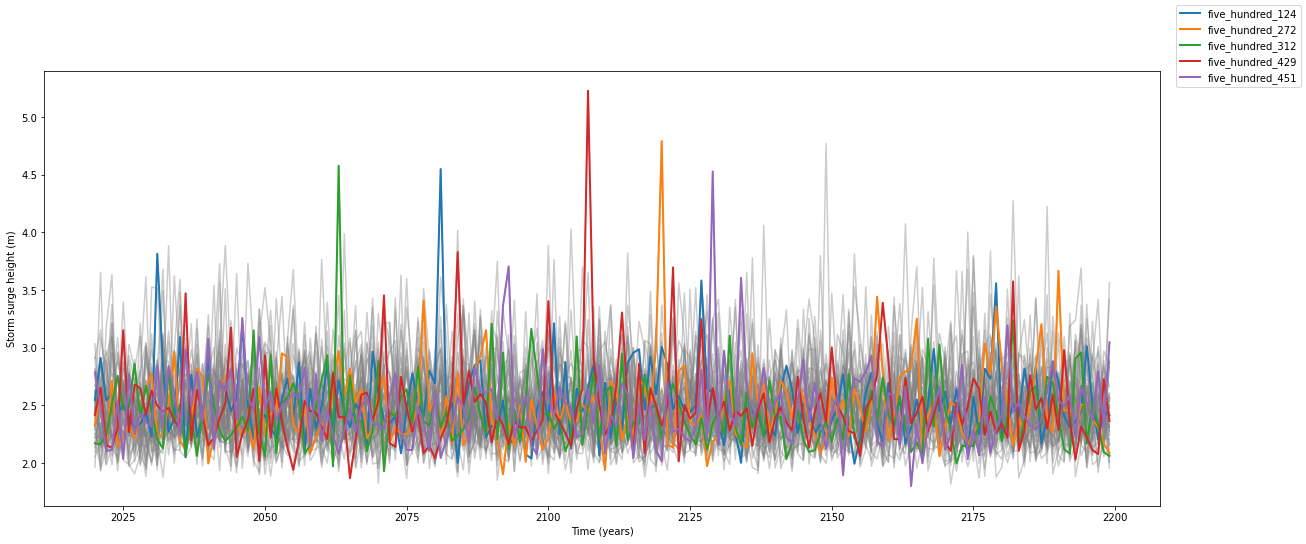

In [43]:
fig, ax = plt.subplots(figsize=(20,8))

for SH in allSurgeHeight:
    nr = int(SH.name.split('_')[2])
    ax.plot(SH.years[0:180],SH.surgeheight[0:180],alpha=0.4,color='grey')
    
for SH in allSurgeHeight:    
    nr = int(SH.name.split('_')[2])
    if nr > 45:
        ax.plot(SH.years[0:180],SH.surgeheight[0:180],label=SH.name,alpha=1,lw=2)
    
fig.legend()
ax.set_xlabel('Time (years)')
ax.set_ylabel('Storm surge height (m)')

path = os.path.join('..','Visualisations','SurgeHeights_biased50.png')
fig.savefig(path,bbox_inches='tight',dpi=150)